In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry import box
import project_path
from db_importer.settings import *
import scipy.stats

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [4]:
start_rect = box(13.3193, 52.5186, 13.3198, 52.5191)
end_rect = box(13.3261, 52.4942, 13.3285, 52.4956)

def get_SUMO_durations(x):
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    vehicle_id = x.iloc[0].vehicle_id
    #print(len(mask_end[mask_end==True]))
    try:
        start = x[mask_first==True].iloc[0].timestep_time
        end = x[mask_end==True].iloc[0].timestep_time
        return (vehicle_id, end - start)
    except: 
        return (vehicle_id, None)
    

In [5]:
files= ['sim_data/chb_default.csv', 'sim_data/chb_default_ped.csv', 'sim_data/chb_new_params.csv', 'sim_data/chb_new_params_ped.csv']

durations_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    if 'ped' in file:
        df.columns = ['timestep_time', 'vehicle_angle', 'edge', 'vehicle_id',
           'vehicle_pos', 'vehicle_slope', 'vehicle_speed', 'vehicle_x', 'vehicle_y']
        df = df[df.vehicle_id.str.startswith('personFlow', na=False)]
    else:
        df = df[df.vehicle_id.str.startswith('flow', na=False)]    
    grouped = df.groupby('vehicle_id')
    durations = grouped.apply(lambda x: get_SUMO_durations(x)[1])
    durations_arr.append(durations.values)

In [7]:
### cf. Thesis Table 6.2

with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       ST_AsGeoJSON(geom) :: json -> 'coordinates' AS coordinates,
       timestamps,
       velos
FROM ride
where st_intersects(ride.geom,
                                         st_setsrid(st_makebox2d(st_makepoint(13.3193, 52.5186),
                                                                 st_makepoint(13.3198, 52.5191)), 4326))
                       AND st_intersects(ride.geom,
                                         st_setsrid(st_makebox2d(st_makepoint(13.3261, 52.4942),
                                                                 st_makepoint(13.3285, 52.4956)), 4326))
  AND st_intersects(start,
                    st_setsrid(st_makebox2d(st_makepoint(13.2935, 52.5153), st_makepoint(13.3385, 52.5301)), 4326))""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])

def get_ride_durations(arr):
    coords = np.array(arr[0])
    timestamps = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (first is not None) & end_rect.contains(point):
            last = i
            break
    try:
        res = (timestamps[last] - timestamps[first]).total_seconds()
    except:
        print('array')
        res = None
    return res

def get_ride_v_max(arr):
    coords = np.array(arr[0])
    velos = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (first is not None) & end_rect.contains(point):
            last = i
            break
    try:
        res = np.max(np.nan_to_num(velos[first:last]))
    except e:
        raise e
        print(e)
        res = None
    return res


test = df.apply(lambda x: get_ride_durations(x[['coords', 'timestamps']].to_numpy()), axis=1)
max_velos = df.apply(lambda x: get_ride_v_max(x[['coords', 'velos']].to_numpy()), axis=1)
test[~test.isnull()].values

np.mean(max_velos)

7.618997535562896

In [8]:
durations_arr.append(test[~test.isnull()].values)

715.9666666666667


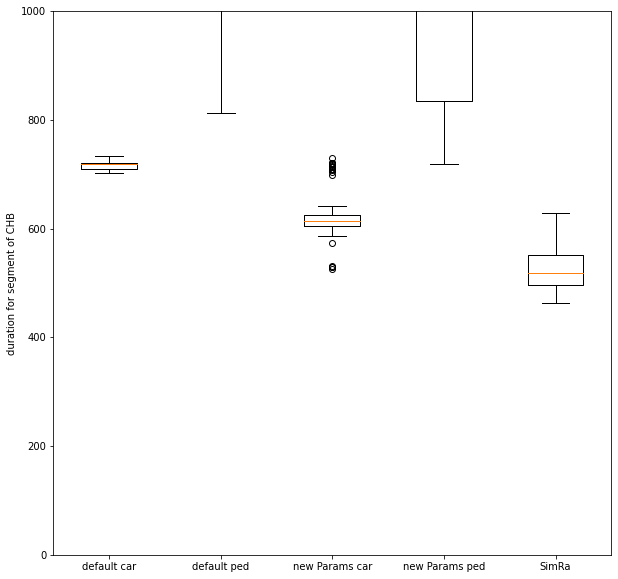

In [11]:
plt.figure(figsize=(10,10))


#plt.boxplot(durations)
plt.boxplot(durations_arr)
plt.xticks(np.arange(len(durations_arr)) + 1, ['default car', 'default ped', 'new Params car', 'new Params ped', 'SimRa'])
plt.ylabel('duration for segment of CHB')
plt.ylim(0, 1000)
plt.savefig('images/sim_CHB.png', bbox_inches='tight')

print(np.mean(durations_arr[0]))

In [14]:
durations_chb = durations_arr

%store durations_chb

Stored 'durations_chb' (list)
